In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [11]:
sb.set()

In [12]:
train_df = pd.read_json("train.json")

In [13]:
train_df.drop('id', axis=1, inplace=True)
train_df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# Exploratory Data Analysis

In [14]:
cuisine_types = train_df['cuisine'].unique()
print(f"There are {len(cuisine_types)} cuisines in the dataset")
cuisine_types

There are 20 cuisines in the dataset


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [18]:
train_df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

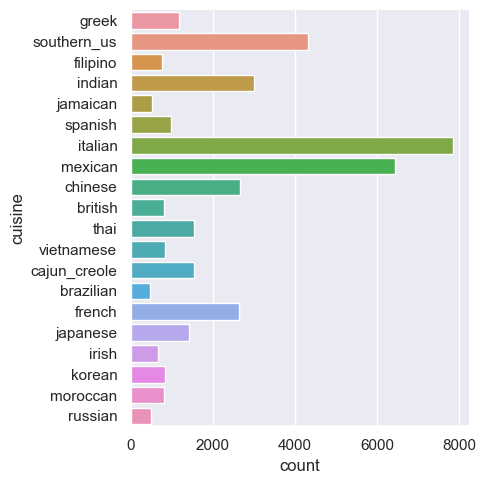

In [17]:
sns.catplot(y='cuisine', data=train_df, kind='count')

We can see that the dataset is very imbalanced. This is something that we have to take into consideration as the models we use may overfit to the data.

In [21]:
ing_count_dict = {}
for recipe in train_df['ingredients']:
    for item in recipe:
        if item not in ing_count_dict.keys():
            ing_count_dict[item] = 1
        else:
            ing_count_dict[item] += 1
            
print(f"Different ingredients in train set: {len(ing_count_dict)}")

Different ingredients in train set: 6714


In [25]:
sorted_ing_count = list(ing_count_dict.items())
sorted_ing_count.sort(key=lambda x:x[1])
print("Top 10 ingredients:")
print(sorted_ing_count[-10:])
print("Bottom 10 ingredients:")
print(sorted_ing_count[:10])

Top 10 ingredients:
[('all-purpose flour', 4632), ('ground black pepper', 4785), ('butter', 4848), ('garlic cloves', 6237), ('sugar', 6434), ('garlic', 7380), ('water', 7457), ('onions', 7972), ('olive oil', 7972), ('salt', 18049)]
Bottom 10 ingredients:
[('white almond bark', 1), ('Johnsonville Andouille Dinner Sausage', 1), ('lemon olive oil', 1), ('Taiwanese bok choy', 1), ('membrillo', 1), ('chestnut flour', 1), ('cinnamon graham crackers', 1), ('chorizo spanish', 1), ('instant butterscotch pudding mix', 1), ('Guinness Lager', 1)]


We can see that there are many different ingredients included in the dataset. Trying to feed all of this data into a model may not work very well as the model may overfit on ingredients that may not be that useful.
  
We can first try to remove the ingredients that are present in a majority of the cuisines. Since such ingredients are present in multiple cuisines, the presence of such ingredients would not allow us to differentiate the cuisines reliably.

In [9]:
onehot_df = pd.DataFrame(np.zeros((len(train_df), len(train_ingredients_count))), columns=train_ingredients_count.keys())

for i in tqdm(range(len(train_df))):
    onehot_df.iloc[i][train_df.iloc[i]['ingredients']] = 1
    
#label_enc = LabelEncoder()
#label_enc.fit(train_df['cuisine'])
#onehot_df['cuisine'] = label_enc.transform(train_df['cuisine'])
onehot_df['cuisine'] = train_df['cuisine']

onehot_df.head()

100%|██████████| 39774/39774 [00:10<00:00, 3909.69it/s]


,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,plain flour,...,Challenge Butter,orange glaze,cholesterol free egg substitute,ciabatta loaf,Lipton® Iced Tea Brew Family Size Tea Bags,Hidden Valley® Greek Yogurt Original Ranch® Dip Mix,lop chong,tomato garlic pasta sauce,crushed cheese crackers,cuisine
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,greek
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,southern_us
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,filipino
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indian
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indian


In [10]:
X_train, X_test, y_train, y_test = train_test_split(onehot_df.drop('cuisine', axis=1), 
                                                    onehot_df['cuisine'], 
                                                    test_size=0.3)

In [11]:
cv = StratifiedKFold(n_splits=5)
mean_accuracy = 0

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), start=1):
    
    fold_X_train, fold_y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    fold_X_test, fold_y_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
    
    model = MultinomialNB()
    model.fit(fold_X_train, fold_y_train)
    
    fold_preds = model.predict(fold_X_test)
    fold_acc = accuracy_score(fold_y_test, fold_preds)
    print(f"Fold {fold}: {fold_acc:.5f}")
    
    mean_accuracy += fold_acc / 5
    
print(f"Mean accuracy: {mean_accuracy:.5f}")

Fold 1: 0.71431
Fold 2: 0.71642
Fold 3: 0.71480
Fold 4: 0.71175
Fold 5: 0.71193
Mean accuracy: 0.71384


Logistic Regression (onehot): 0.76811  
PassiveAggressiveClassifier (onehot): 0.71678  
Decision Tree (onehot): 0.59200  
ComplementNB (onehot): 0.71244  
MultinomialNB (onehot): 0.71413  
BernoulliNB (onehot): 0.66582  
GaussianNB (onehot): 0.39632  
Random Forest (onehot): 0.70109  

In [13]:
model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
classification_report = classification_report(y_test, y_preds)

In [14]:
print(classification_report)

              precision    recall  f1-score   support

   brazilian       0.75      0.57      0.65       137
     british       0.50      0.42      0.46       222
cajun_creole       0.78      0.68      0.73       461
     chinese       0.77      0.84      0.81       798
    filipino       0.75      0.55      0.63       270
      french       0.57      0.62      0.60       750
       greek       0.77      0.69      0.73       343
      indian       0.85      0.88      0.86       858
       irish       0.55      0.45      0.49       186
     italian       0.79      0.88      0.83      2335
    jamaican       0.80      0.64      0.71       168
    japanese       0.79      0.71      0.75       424
      korean       0.85      0.72      0.78       265
     mexican       0.88      0.92      0.90      1932
    moroccan       0.80      0.72      0.76       240
     russian       0.67      0.51      0.58       153
 southern_us       0.71      0.79      0.75      1337
     spanish       0.59    

# Feature Selection

In [33]:
ingredients = onehot_df.drop('cuisine', axis=1).columns
X, y = onehot_df.drop('cuisine', axis=1), onehot_df['cuisine']
cv = StratifiedKFold(n_splits=5)   

In [34]:
# get baseline

baseline_acc = 0

for (train_idx, test_idx) in cv.split(X, y):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_test)
    baseline_acc += accuracy_score(y_test, y_preds) / 5
    
print(f"Baseline accuracy: {baseline_acc:.5f}")

Baseline accuracy: 0.73103


In [39]:
from feature_engine.selection import DropConstantFeatures

X_reduced = DropConstantFeatures(tol=0.999).fit_transform(X)
X_reduced.shape

(39774, 1137)

In [40]:
# get baseline

reduced_acc = 0

for (train_idx, test_idx) in cv.split(X_reduced, y):
    
    X_train, y_train = X_reduced.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X_reduced.iloc[test_idx], y.iloc[test_idx]
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_test)
    reduced_acc += accuracy_score(y_test, y_preds) / 5
    
print(f"Reduced accuracy: {reduced_acc:.5f}")

Reduced accuracy: 0.72507


In [27]:
bad_cols = []
elim_count = 0

for count, ingredient in enumerate(ingredients, start=1):
    
    X_reduced = X.drop(bad_cols, axis=1)
    
    trial_acc = 0
    
    for (train_idx, test_idx) in cv.split(X_reduced, y):
    
        X_train, y_train = X_reduced.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X_reduced.iloc[test_idx], y.iloc[test_idx]

        model = MultinomialNB()
        model.fit(X_train, y_train)

        y_preds = model.predict(X_test)
        trial_acc += accuracy_score(y_test, y_preds) / 5
        
    if trial_acc > baseline_acc:
        bad_cols.append(ingredient)
        elim_count += 1
        print(f"Ingredient eliminated: {ingredient} \t ({elim_count} / {count} eliminated)")

KeyboardInterrupt: 

In [ ]:
bad_cols

In [61]:
cuisine_top_n = {}
for cuisine in cuisine_types:
    cuisine_ingredient_count = {}
    cuisine_df = train_df[train_df['cuisine'] == cuisine]
    for i in tqdm(range(len(cuisine_df))):
        ingredients = cuisine_df.iloc[i]['ingredients']
        for ingredient in ingredients:
            if ingredient not in cuisine_top_n.keys():
                cuisine_top_n[ingredient] = 1
            else:
                cuisine_top_n[ingredient] += 1
                
    top_n_ingredients = sorted(list(cuisine_top_n.items()), key=lambda x: x[1])
    top_n_ingredients = top_n_ingredients[:10]
    top_n_ingredients = [ingredient[0] for ingredient in top_n_ingredients]
    cuisine_top_n[cuisine] = top_n_ingredients

100%|██████████| 4320/4320 [00:00<00:00, 27962.72it/s]


TypeError: '<' not supported between instances of 'list' and 'int'